В предыдущей части не вышло у меня последовательно собрать домены. Ну как, вышло частично, только очень медленно, так что лучше бы и выходило совсем. Поэтому после доооооолгого курения stackoverflow решил попробовать запускать реквесты в concurrent.futures. Кроме того, вряд ли есть нужда ходить по всем ссылкам, можно ограничиться только доменами, и пособирать тайтлы, дескрипшены и кейворды.

In [ ]:
#base
import os, sys
import datetime
from scipy import stats
import numpy as np
import pandas as pd
import re
import json
import pickle
from urllib.parse import urlparse
from urllib.request import urlretrieve, unquote
from collections import Counter
from collections import OrderedDict
import concurrent.futures
import time
import multiprocessing
import gc
#text block
import unicodedata
#requests block
import bs4
from bs4 import BeautifulSoup
import requests
#text
import pymorphy2
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from pymystem3 import Mystem
#vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer
#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
#validation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#pipeline block
from sklearn.pipeline import Pipeline
#visuals
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
%matplotlib inline

# progress bar
from tqdm import tqdm, tqdm_notebook

# instantiate
tqdm.pandas(tqdm_notebook)

In [2]:
%%time
file_path = '/data/share/project01/gender_age_dataset.txt'
raw_data = pd.read_csv(file_path, sep='\t')

CPU times: user 7.98 s, sys: 7.88 s, total: 15.9 s
Wall time: 15.9 s


In [16]:
%%time
def load_user_json(user_jsons):
    return user_jsons.map(json.loads)

def url2domain(url):
    url = re.sub('(http(s)*://)+', 'http://', url)
    parsed_url = urlparse(unquote(url.strip()))
    if parsed_url.scheme not in ['http','https']: return None
    netloc = re.search("(?:www\.)?(.*)", parsed_url.netloc).group(1)
    if netloc is not None: return str(netloc.encode('utf8')).strip()
    return None

df=raw_data.copy()
df['user_json'] = load_user_json(df['user_json'])
df['url_list'] = df['user_json'].map(lambda x: [visit['url'] for visit in x['visits']])


CPU times: user 1min 32s, sys: 2.46 s, total: 1min 34s
Wall time: 1min 35s


Есть мысль посмотреть в зубы, насколько вообще хорошо дареная нам функция выцепления доменов справляется со своей работой. Соберем сет всех url и глянем, на чем она выдает None

In [55]:
%%time
df['trojan_domain'] = df['user_json'].map(lambda x: [url2domain(visit['url']) for visit in x['visits']])

CPU times: user 1min 23s, sys: 2.16 s, total: 1min 25s
Wall time: 1min 25s


In [74]:
trojan_set = set([url for url_list in df.trojan_domain for url in url_list])
len(trojan_set)

116988

In [93]:
def look_into_teeth(url_list):
    result = []
    for url in url_list:
        url = re.sub('(http(s)*://)+', 'http://', url)
        parsed_url = urlparse(unquote(url.strip()))
        #если нет схемы, запишем url
        if parsed_url.scheme not in ['http','https']: result.append(('scheme', url))
        netloc = re.search("(?:www\.)?(.*)", parsed_url.netloc).group(1)
        #если нет нетлока, запишем url
        if netloc is None: result.append(('netloc', url))
    return result

In [5]:
url_set = set([url for url_list in df.url_list for url in url_list])  

In [6]:
len(url_set)

1837091

In [81]:
suspicious = look_into_teeth(url_set)
suspicious

[]

Ок, опасения оказались напрасными, эта штука работает прекрасно. Все равно на всякий случай посмотрим, как в целом могут выглядеть наши ссылки

In [89]:
try_reg = ['', 'http[s]?://', 'http://http://', 'https://https://', '://.+/', 
           'http[s]?://www\.', 'http[s]?(www.)?([^/])+/']

In [85]:
def search_strange(url_list, reg_exp):
    counter = 0
    for url in url_list:
        x = re.search(reg_exp, url)
        if x: counter+=1
    return reg_exp, counter

In [90]:
for item in try_reg:
    print(search_strange(url_set, item))

('', 1837091)
('http[s]?://', 1837091)
('http://http://', 118072)
('https://https://', 0)
('://.+/', 1836645)
('http[s]?://www\\.', 711654)
('http[s]?(www.)?([^/])+/', 1837091)


Похоже, что ВСЕ ссылки содержат http[s]?, 40% из них содержат www, 118072 содержат дубликат http://, не существует дубликатов https. Поскольку собрались ходить по доменам, извлечем полную ссылку на домен со схемой.

In [53]:
def re_domain_for_scrap(url):
    result = re.match(r'(http[s]?://)+(www.)?([^/]*)', url)[0].replace('http://http','http')
    if result is not None: return result
    if result is None : return None

In [54]:
%%time
df['domain'] = df['url_list'].map(lambda x: [re_domain_for_scrap(url) for url in x])

CPU times: user 15.2 s, sys: 1.12 s, total: 16.3 s
Wall time: 16.4 s


In [96]:
scrap_urls = set([url for url_list in df.domain for url in url_list])
len(scrap_urls)

125010

Итак, у нас было 1837091 уникальных ссылок, 125010 уникальных доменных ссылок со своими схемами, 8 ядер, 8 гигов на собственном ноутике и пачка сигарет. Не то, чтобы это всё было нужно в поездке, но раз начал коллекционировать ссылки, то иди в своём увлечении до конца. Единственное, что меня беспокоило — это суп. В мире нет никого более беспомощного, безответственного и безнравственного, чем суп, пожирающий оперативу. И я знал, что довольно скоро мы в это окунёмся...
Ну ладно, тогда еще не знал, узнал лишь в процессе.

In [ ]:
def get_response(url, timeout=2):
    HEADER = {'user-agent': "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:77.0) Gecko/20190101 Firefox/77.0"}
    try:
        response = requests.get(url, headers=HEADER, timeout=timeout)
        if response.status_code == 200:
            return [response, url]
    except: 
        return None
    
def get_metas_1252(response, url=None, encod='cp1252'):
    if response.status_code == 200:
        soup1 = BeautifulSoup(response.text, 'lxml')
        soup2 = BeautifulSoup(response.text.encode(encod, 'ignore'), 'lxml')
        try:
            ttext1 = str(soup1.title.string)# вот эти стринги сильно уменьшили пожирание памяти
            ttext2 = str(soup2.title.string)
        except:
            ttext1=None
            ttext2=None
        
        metas1 = soup1.find_all('meta')
        tdesc1 = ''.join([meta.attrs['content'] for meta in metas1 if 'name' in meta.attrs and 'content' in meta.attrs 
                 and meta.attrs['name'] == 'description']).strip()
        tkeyw1 = ''.join([meta.attrs['content'] for meta in metas1 if 'name' in meta.attrs and 'content' in meta.attrs 
                 if 'name' in meta.attrs and meta.attrs['name'] == 'keywords']).strip()
        del metas1
        metas2 = soup2.find_all('meta')
        tdesc2 = ''.join([meta.attrs['content'] for meta in metas2 if 'name' in meta.attrs and 'content' in meta.attrs 
                 and meta.attrs['name'] == 'description']).strip()
        tkeyw2 = ''.join([meta.attrs['content'] for meta in metas2 if 'name' in meta.attrs and 'content' in meta.attrs 
                 if 'name' in meta.attrs and meta.attrs['name'] == 'keywords']).strip()
        del metas2
        soup1.decompose()#вот эти шайтан-штуковины тоже помогли оперативе
        soup2.decompose()
        del soup1, soup2
        return [url, ttext1, tdesc1, tkeyw1, ttext2, tdesc2, tkeyw2]
    else: return None

Цель - собрать реквест с домена, получить с него 200-й респонс, собрать title, собрать meta description и meta keywords. После пары случайных единичных прогонов выяснилось, что некоторые прекрасные домены, видимо, неправильно указывают кодировку, и иногда от этой болезни помогало прямое указание cp1252. Так что в итоге собиралась и та кодировка, которую распознавал суп, и 1252. В ранних попытках примерно к 2500 урлам это благолепие обожралось памяти и улеглось без движения. Все получилось, когда я почистил функцию с супом, разбил запросы на чанки по 2500, и начал делать после каждого чанка gc.collect. 500 и более воркеров приводили к непонятному падению сети - то ли роутер не справлялся, то ли провайдер начинал что-то подозревать. Поэтому сделал по рекомендованному числу - 5*кол-во ядер.

In [ ]:
# CONNECTIONS = multiprocessing.cpu_count() * 5
# TIMEOUT = 2

# result_total=[]
# chunks = [i for i in range(0, len(scrap_urls), 2500)]

# def load_url(url, timeout):
#     return get_response(url, timeout=timeout)

# for i in chunks:
#     if i==125000: a, b = i, len(scrap_urls)+1
#     else: a, b = i, i+2500

#     urls = scrap_urls[a:b]
#     result=[]
#     with concurrent.futures.ThreadPoolExecutor(max_workers=CONNECTIONS) as executor:
#         future_to_url = (executor.submit(load_url, url, TIMEOUT) for url in urls)
#         time1 = time.time()
#         for future in concurrent.futures.as_completed(future_to_url):
#             try:
#                 resp = future.result()
#             except:
#                 resp = None
#             finally:
#                 if resp is not None:
#                     result.append(get_metas_1252(resp[0], url=resp[1]))
#                 del future
#                 del resp
#                 print(str(len(result)),end="\r")

#     time2 = time.time()
#     del executor
#     del future_to_url
#     gc.collect()
#     result_total+=result
#     print(i, f'Took {time2-time1:.2f} s')
#     print(str(len(result_total)))

0 Took 150.32 s
1846
2500 Took 151.11 s
3716
5000 Took 147.82 s
5560
7500 Took 161.83 s
7422
10000 Took 151.82 s
9265
12500 Took 156.51 s
11129
15000 Took 158.36 s
13019
17500 Took 159.21 s
14899
20000 Took 160.83 s
16779
22500 Took 164.92 s
18668
25000 Took 154.81 s
20527
27500 Took 161.64 s
22394
30000 Took 160.57 s
24256
32500 Took 178.79 s
26116
35000 Took 183.41 s
27964
37500 Took 183.22 s
29871
40000 Took 180.27 s
31766
42500 Took 187.32 s
33629
45000 Took 172.74 s
35489
47500 Took 182.48 s
37387
50000 Took 161.39 s
39224
52500 Took 163.83 s
41098
55000 Took 167.67 s
42962
57500 Took 159.01 s
44803
60000 Took 170.66 s
46672
62500 Took 169.84 s
48556
65000 Took 173.81 s
50407
67500 Took 170.16 s
52266
70000 Took 169.35 s
54139
72500 Took 201.05 s
56031
75000 Took 179.07 s
57861
77500 Took 169.97 s
59733
80000 Took 168.14 s
61612
82500 Took 173.82 s
63468
85000 Took 176.99 s
65292
87500 Took 171.32 s
67197
90000 Took 181.82 s
69044
92500 Took 196.34 s
70926
95000 Took 172.88 s
72771
97500 Took 175.35 s
74640
100000 Took 172.64 s
76475
102500 Took 177.18 s
78301
105000 Took 174.50 s
80113
107500 Took 174.16 s
81950
110000 Took 164.50 s
83752
112500 Took 169.80 s
85593
115000 Took 184.84 s
87455
117500 Took 175.62 s
89304
120000 Took 182.95 s
91174
122500 Took 196.32 s
93027
125000 Took 3.07 s
93035

Заняло это порядка трех часов, причем после успешного завершения половины реквестов я укорял себя за максимализм и желание сделать все в одном цикле(читай: очковал, что вот щаз оно сломается, или интернет пропадет). Но все прошло без ошибок, около 75% доменов вернули 200 респонс и, я надеялся, хоть какой-то текст. Сразу по завершению я дрожащими руками спиклил драгоценный список.

In [ ]:
# model_file = "scrap_list.pickle"

# with open(os.environ['HOME'] + '/' + model_file, 'wb') as f:
#     pickle.dump(result_total, f)
    
# os.chmod(os.environ['HOME'] + '/' + model_file, 0o644)

In [95]:
list_file = "scrap_list.pickle"
result_total = pickle.load(open(list_file, 'rb'))

df_scrap=pd.DataFrame(result_total,columns=['domain', 'title', 'description', 
                                       'keywords','title1252', 'description1252', 'keywords1252'])
df_scrap.head(2)

domain                                              title  \
0  http://capsula.spb.ru                   Creotech / создание IT ресурсов    
1    http://www.zawod.ru  Çàâîä.ðó - ñïðàâî÷íèê ïî ñïèñêó èç êàòàëîã ïðî...   

  description keywords                                          title1252  \
0                                                        Creotech /  IT     
1                       Завод.ру - справочник по списку из каталог про...   

  description1252 keywords1252  
0                               
1

Как раз та ситуация с cp1252: да, собиралось подольше, но получили нормальный текст. Сделаем отдельно тайтлы, отдельно весь текст

In [98]:
%%time
txt_cols = [c for c in df_scrap.columns if c!='domain']
title_cols = ['title', 'title1252']
df_scrap.fillna(value='', inplace=True)
df_scrap['text'] = df_scrap[txt_cols].apply(lambda x:" ".join(x), axis=1)
df_scrap['headers'] = df_scrap[title_cols].apply(lambda x:" ".join(x), axis=1)

CPU times: user 4.47 s, sys: 68 ms, total: 4.54 s
Wall time: 4.55 s


Возьмем все русские и латинские буквы, которые встретились в тексте, и токенизируем текст. Соорудим словарик домен - лист токенов, и вернемся к основному датафрейму

In [100]:
import pymorphy2
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from pymystem3 import Mystem

In [102]:
def token_all(text):
    result=[]
    text = re.sub('[^а-яА-Яa-zA-Z]', ' ', text)
    result += text.lower().split()
    return result

In [104]:
%%time
df_scrap['clean_text'] = df_scrap.text.map(token_all)

CPU times: user 4.07 s, sys: 888 ms, total: 4.96 s
Wall time: 4.99 s


In [105]:
df_scrap_dict=df_scrap[['domain', 'clean_text']]
domain_dict = df_scrap_dict.set_index('domain').clean_text.to_dict()

In [107]:
def apply_scrap_dict(urls, domain_dict=domain_dict):
    result=[]
    for url in urls:
        try: result.append(' '.join(domain_dict[url]))
        except: pass
    return ' '.join(result).split()

In [108]:
%%time
df['scrap_text'] = df.domain.map(apply_scrap_dict)
scrap_words = set([word for text in df.scrap_text for word in text])

CPU times: user 58.6 s, sys: 56.3 s, total: 1min 54s
Wall time: 1min 55s


In [109]:
len(scrap_words)

186988

Ок, у нас есть сет слов из текста доменов, нужно их лемматизировать. Кириллицу - pymorphy, латиницу - nltk.stem. Если в одном токене есть и латиница, и кириллица, штош, ему не повезло. Все равно pymorphy.

In [111]:
morph = pymorphy2.MorphAnalyzer()
Lem = WordNetLemmatizer()

In [112]:
def normalize_word(word):
    if re.search('[а-яА-Я]', word) is not None:
        return morph.parse(word)[0].normal_form
    elif re.search('[a-zA-Z]', word) is not None:
        return Lem.lemmatize(word)
    else: return word

In [113]:
scrap_normalized_dict=dict()
for word in tqdm(scrap_words):
    scrap_normalized_dict[word] = normalize_word(word)

100%|██████████| 186988/186988 [00:50<00:00, 3688.16it/s]


In [114]:
scrap_normalized_dict

{'деятельности': 'деятельность',
 'баннерообмен': 'баннерообмен',
 'печные': 'печный',
 'sradio': 'sradio',
 'популярную': 'популярный',
 'мощь': 'мощь',
 'многоквартирный': 'многоквартирный',
 'agdb': 'agdb',
 'orel': 'orel',
 'вредный': 'вредный',
 'железнодорожных': 'железнодорожный',
 'авилон': 'авилон',
 'piligrim': 'piligrim',
 'автокраски': 'автокраска',
 'нештатной': 'нештатный',
 'performed': 'performed',
 'нстытут': 'нстытут',
 'материнские': 'материнский',
 'airidaco': 'airidaco',
 'автоrnmeta': 'автоrnmeta',
 'автовладелец': 'автовладелец',
 'тесно': 'тесно',
 'рыбакам': 'рыбак',
 'ишиме': 'ишим',
 'капот': 'капот',
 'сандер': 'сандёр',
 'ходченкова': 'ходченков',
 'yubileiniy': 'yubileiniy',
 'рассорка': 'рассорка',
 'лково': 'лковый',
 'алфавитном': 'алфавитный',
 'кама': 'кама',
 'климатис': 'климатис',
 'гарантированного': 'гарантировать',
 'акваскейп': 'акваскейп',
 'займется': 'заняться',
 'filtorg': 'filtorg',
 'uniview': 'uniview',
 'рая': 'рая',
 'luzhny': 'luzhny'

Теперь у нас есть словарик лемм для каждого токена, встретившегося в текстах доменов. Корявенько, но дальнейшие фильтры частоты в векторайзерах могут поправить дело. Но что нам НА САМОМ ДЕЛЕ нужно, так это словарь домен - лемматизированные токены. Все равно в решающий момент мы на незнакомый домен не пойдем - не получится по времени. Поэтому проще и быстрее всего заранее подготовить словарь, а в нужный момент достать его из широкого пикла и применить к боевому домену. Остается только надеяться, что большая часть доменов на валидейшене не встретится нам в первый раз.

In [117]:
def normalize_by_dict(words, scrap_normalized_dict=scrap_normalized_dict):
    result = []
    for word in words:
        if all([word not in russian_stopwords, word not in english_stopwords, len(word)>3]):
            result.append(scrap_normalized_dict[word])
    return result

In [119]:
russian_stopwords = stopwords.words("russian")
english_stopwords = stopwords.words("english")

In [120]:
%%time
df_scrap['clean_text'] = df_scrap.text.map(token_all)
df_scrap['normalized_text'] = df_scrap.clean_text.map(normalize_by_dict)

CPU times: user 36.3 s, sys: 1.11 s, total: 37.4 s
Wall time: 37.5 s


In [121]:
domain_dict_text = df_scrap[['domain', 'normalized_text']].set_index('domain').normalized_text.to_dict()

In [122]:
domain_dict_text

{'http://capsula.spb.ru': ['creotech', 'создание', 'ресурс', 'creotech'],
 'http://www.zawod.ru': ['завод',
  'справочник',
  'список',
  'каталог',
  'промышленный',
  'предприятие',
  'россия',
  'страна'],
 'http://kursall.ru': ['видеокурс',
  'видеоурок',
  'обучать',
  'видео',
  'тренинг',
  'главный',
  'страница',
  'видеокурс',
  'видеокурс',
  'видеоурок',
  'обучать',
  'видео',
  'русский',
  'язык',
  'также',
  'электронный',
  'книга',
  'тренинг',
  'аудиокурс',
  'материал',
  'обучение',
  'саморазвитие',
  'самообразование',
  'видеокурс',
  'видеоурок',
  'обучать',
  'видео',
  'тренинг',
  'аудиокурс',
  'обучать',
  'видео',
  'книга',
  'обучение',
  'купить',
  'видеокурс',
  'купить',
  'видеокурс',
  'видео',
  'обучение',
  'видеокурс',
  'фотошоп',
  'видеокурс',
  'бизнес',
  'видеокурс',
  'flash',
  'скачать',
  'видеокурс',
  'создание',
  'сайт',
  'создание',
  'блог',
  'сайт',
  'видеокурс',
  'видео',
  'урок',
  'раскрутка',
  'сайт',
  'flash',
 

Мне нравится результат. Спиклим словарь, и будем его далее использовать на основном датафрейме.

In [ ]:
# scrap_dict_text_file = "scrap_text_headers.pickle"
# with open(os.environ['HOME'] + '/' + scrap_dict_text_file, 'wb') as f:
#     pickle.dump(domain_dict_text, f)
    
# os.chmod(os.environ['HOME'] + '/' + scrap_dict_text_file, 0o644)

In [123]:
def apply_scrap_dict_text(urls, domain_dict=scrap_dict_text):
    result=[]
    for url in urls:
        try: result.append(' '.join(domain_dict[url]))
        except: pass
    return ' '.join(result).split()

In [124]:
df['scrap_text'] = df.domain.map(set).map(apply_scrap_dict_text)

Теперь можно собрать bag of words на словах из текста доменов. Посмотрим хотя б, что вышло - посредством вордклауда

In [158]:
from wordcloud import WordCloud
from PIL import Image
from io import BytesIO
def draw_cloud(series, mc, gap=0):
    c=Counter()
    for word in [word for text in series for word in text]:
        c[word] += 1
    text = dict(c.most_common(mc)[gap:])
    response = requests.get("https://i.pinimg.com/474x/af/3e/ed/af3eeda017287cbe230ed00c4c76afbd.jpg")
    mask = np.array(Image.open(BytesIO(response.content)))
    wordcloud = WordCloud(max_font_size=50, background_color="white", 
                          max_words=mc-gap, mask=mask).generate_from_frequencies(text)
    plt.figure(figsize=(20,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

M


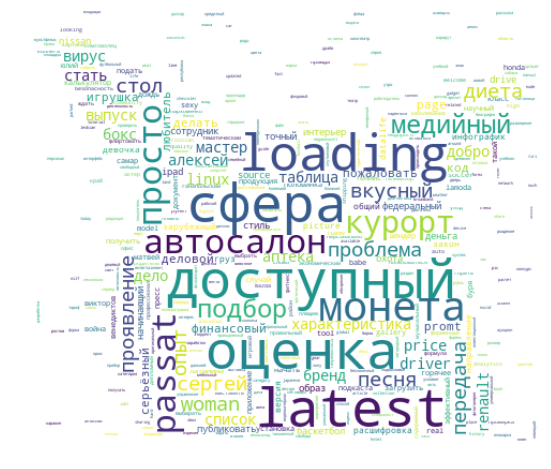

F


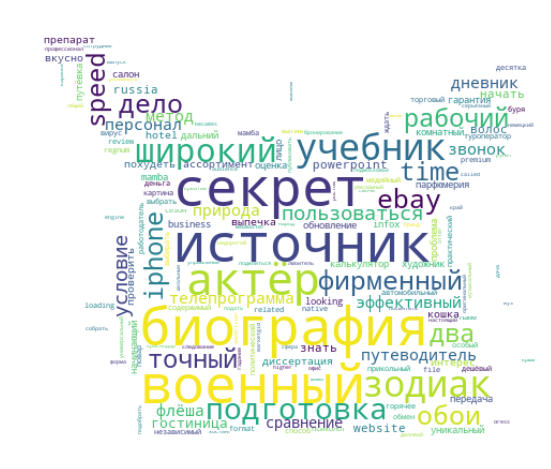

In [163]:
for gender in ['M', 'F']:
    print(gender)
    draw_cloud(df[df.gender==gender].scrap_text, 1000, 500)

Кажется, нормально вышло. Погоняем bow.

In [168]:
df['class'] = df.gender + ' ' + df.age
df1=df[df.gender!='-']
features = ['domain', 'scrap_text']
target='class'
target1='gender'
target2='age'

Сделаем штуку, считающую помимо обычного accuracy еще и, что будет, если взять только предсказания выше медианы, и предсказания с наибольшим отрывом от второго класса

In [164]:
def report4(pipeline, X_train, X_test, y_train, y_test, tags, target):

    predicts_prob = pipeline.predict_proba(X_test)
    predicts = pipeline.predict(X_test)
    proba = pd.Series([max(predicts_prob[i]) for i in range(len(predicts_prob))])
    proba_diff = pd.Series([(sorted(predicts_prob[i],reverse=True)[0]-sorted(predicts_prob[i],reverse=True)[1]) 
                            for i in range(len(predicts_prob))])
    out = pd.DataFrame()
    out['y'] = y_test.reset_index()[target]
    out['pred'] = predicts
    out['prob'] = proba
    out['prob_diff'] = proba_diff
    out['correct'] = out.y==out.pred
    print('accuracy %s' % accuracy_score(predicts, y_test))
    print('prob_cut_accuracy %s' % out[out.prob>=out['prob'].median()].correct.mean())
    print('prob_diff_cut_accuracy %s' % out[out.prob_diff>=out['prob_diff'].median()].correct.mean())

Посчитаем логрег, no fancy stuff, только бинарный векторайзер без idf. Минимум 10 юзеров посещали домены с таким словом, не более чем 80% юзеров имеют в списке такое слово. Токенизатор не нужен - все уже готово, lowercase тоже не нужен, да он и сломается на списке, а не на строке.

In [171]:
train_target = target
X_train, X_test, y_train, y_test = train_test_split(df1['scrap_text'], 
                                                    df1[train_target], 
                                                    test_size=0.20, 
                                                    random_state=42)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x:x, lowercase=False, sublinear_tf=False, ngram_range=(1,1),
                              binary=True, use_idf=False, min_df=10, max_df=0.8)),
    ('clf', LogisticRegression(max_iter=300, solver='saga', penalty='l2', C=1))])

pipeline.fit(X_train, y_train)

tags=df1[train_target].unique()
report4(pipeline, X_train, X_test, y_train, y_test, tags, train_target)

accuracy 0.30893746541228556
prob_cut_accuracy 0.37216380741560595
prob_diff_cut_accuracy 0.36579966795794133


Очень даже неплохо. А если наивный Байес?

In [174]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x:x, lowercase=False, sublinear_tf=False, ngram_range=(1,1),
                              binary=True, use_idf=False, min_df=10, max_df=0.8)),
    ('clf', MultinomialNB(alpha=1))])
pipeline.fit(X_train, y_train)
report4(pipeline, X_train, X_test, y_train, y_test, tags, train_target)

accuracy 0.2927504150525733
prob_cut_accuracy 0.34587714443829554
prob_diff_cut_accuracy 0.34715312327252623


Похуже, но тоже можно жить. Погридсерчим как-нибудь в следующий раз, еще не все возможные фичи добыли.